In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import random 

Define the Unet Model 

# Forward process

## 数据预处理

In [5]:
import pandas as pd 

train_data = pd.read_csv('trainning_data_merged.csv')

In [6]:
# 选取 country是中国的作为train_data
train_data = train_data[train_data['country'] == 'China'].reset_index(drop=True)
# train_data = train_data.head()

## Deal with data 

Ticker 和 asset_underlying 的逻辑是重复的 我们去掉Ticker

In [7]:
train_data.drop(columns=['ticker'], inplace=True)

归一化处理日期

In [8]:
# 1. 合约期限（归一化到年）
# contract_days = train_data['contract_calendar_days'] / 365.0

train_data['contract_calendar_days'] = train_data['contract_calendar_days'] / 365.0

# 2. 实际交易日（归一化到年）
train_data['actual_trading_days'] = train_data['actual_trading_days'] / 252
# trading_days = actual_trading_days / 252

# 3. 交易日比例
# trading_ratio = trading_days / contract_days
train_data['trading_ratio'] = train_data['actual_trading_days'] / train_data['contract_calendar_days']
         

处理 price series: 将 price_series 从字符串（如 "[100, 101, 102]"）解析为 numpy 数组

In [9]:
import torch
import re

def parse_price_series(price_list):
    """
    修复版：正确处理价格序列，避免匹配到单独的 '.'
    """
    # 将所有字符串连接
    combined = ''.join(str(item) for item in price_list)
    
    # 使用更精确的正则表达式：匹配整数或小数
    # \d+\.\d+ 匹配小数（如 6139.29）
    # \d+ 匹配整数（如 100）
    numbers = re.findall(r'\d+\.\d+|\d+', combined)
    
    # 转换为浮点数并创建 tensor
    return torch.tensor([float(n) for n in numbers], dtype=torch.float32)

# 应用到整个列
train_data['price_series'] = train_data['price_series'].apply(parse_price_series)

# 验证
print(f"第一个价格序列: {train_data['price_series'][0]}")
print(f"长度: {len(train_data['price_series'][0])}")

第一个价格序列: tensor([6139.2900, 6168.6602, 6252.0801, 6109.2900, 6336.6299, 6465.7300,
        6568.6401, 6502.0698, 6642.6099, 6693.8101, 6666.2598, 6625.0098,
        6546.6001, 6535.8999, 6654.5498, 6653.3398, 6654.0801, 6526.9502,
        6474.8198, 6555.8198, 6645.5098, 6703.8198, 6815.8501])
长度: 23


把start_price column的名字 改为 S_0

In [10]:
train_data.rename(columns={'start_price': 'S_0'}, inplace=True)

获取对数收益率

Demo 逻辑

In [11]:
# log_returns = torch.diff(torch.log(train_data['price_series'][1]))
# # 收益率会减少一位
# print(log_returns)

# scaled_returns = log_returns

# # 创建固定长度序列
# target = torch.zeros(252)
# mask = torch.zeros(252)

# # 设置起始标记
# target[0] = 1.0
# mask[0] = 1.0

# # 填充收益率（最多251个）
# num_to_fill = min(len(scaled_returns), 251)
# target[1:1 + num_to_fill] = scaled_returns[:num_to_fill]
# mask[1:1 + num_to_fill] = 1.0

# # 保存
# mask,target

In [12]:
def process_multiple_rows(price_series_column, max_length=252):
    """
    处理多行价格序列数据
    
    参数:
        price_series_column: pandas Series，包含多个价格序列（tensor）
        max_length: 目标序列长度，默认252
    
    返回:
        targets: 形状为 (n_samples, max_length) 的 tensor
        masks: 形状为 (n_samples, max_length) 的 tensor
    """
    n_samples = len(price_series_column)
    targets = torch.zeros(n_samples, max_length)
    masks = torch.zeros(n_samples, max_length)
    
    for i in range(n_samples):
        # 获取第 i 行的价格序列
        price_seq = price_series_column.iloc[i]
        
        # 计算对数收益率
        log_returns = torch.diff(torch.log(price_seq))
        
        # 设置起始标记
        targets[i, 0] = 1.0
        masks[i, 0] = 1.0
        
        # 填充收益率（最多 max_length-1 个）
        num_to_fill = min(len(log_returns), max_length - 1)
        targets[i, 1:1 + num_to_fill] = log_returns[:num_to_fill]
        masks[i, 1:1 + num_to_fill] = 1.0
    
    return targets, masks

# 使用示例
targets, masks = process_multiple_rows(train_data['price_series'])
print(f"targets 形状: {targets.shape}")
print(f"masks 形状: {masks.shape}")

targets 形状: torch.Size([32092, 252])
masks 形状: torch.Size([32092, 252])


Using embedding to achieve ticker_id

In [13]:
unique_tickers = sorted(train_data["asset_underlying"].unique())

ticker2id = {t: i for i, t in enumerate(unique_tickers)}
id2ticker = {i: t for t, i in ticker2id.items()}  # 可选：反向映射

# 3. 在 df 中新增一列 ticker_id
train_data["asset_underlying_id"] = train_data["asset_underlying"].map(ticker2id).astype("int64")
train_data.drop(columns=['asset_underlying'], inplace=True)

one-hot country as 0 and 1

In [14]:
train_data["country"] = train_data["country"].map({"USA": 0, "China": 1})

综合数据情况

In [15]:
X_train = train_data.drop(columns=['price_series', 'start_date','expected_trading_days','actual_trading_days'])

# trading_ratio 是需要的， contract_calendar_days是需要的
y_train = targets
X_train.head()

## Add noise 

,contract_calendar_days,S_0,volatility,risk_free_rate,country,trading_ratio,asset_underlying_id
0,0.082192,6139.29,0.212546,0.047990,1,1.062169,0
1,0.082192,6168.66,0.212604,0.047970,1,1.013889,0
2,0.082192,6252.08,0.210737,0.047930,1,0.965608,0
3,0.082192,6109.29,0.210879,0.047900,1,1.013889,0
4,0.082192,6336.63,0.212102,0.048465,1,0.965608,0


In [16]:
y_train

tensor([[ 1.0000e+00,  4.7722e-03,  1.3433e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  1.3433e-02, -2.3104e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00, -2.3104e-02,  3.6537e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 1.0000e+00,  9.5148e-03, -4.1008e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00, -4.1008e-04, -2.6302e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00, -2.6302e-03, -1.2024e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

## 数据后处理

In [17]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("需要缩放的数值列:", numeric_cols)
scaler = RobustScaler()

cols_to_scale = ['S_0', 'contract_calendar_days', 'trading_ratio']

X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

print("缩放完成")
print(X_train_scaled[cols_to_scale].describe())

import joblib
# 保存 scaler，用于推理时转换新数据
joblib.dump(scaler, 'scaler.pkl')

需要缩放的数值列: ['contract_calendar_days', 'S_0', 'volatility', 'risk_free_rate', 'country', 'trading_ratio', 'asset_underlying_id']
缩放完成
                S_0  contract_calendar_days  trading_ratio
count  32092.000000            32092.000000   32092.000000
mean       0.073604                0.455096      -0.065099
std        0.619840                0.825847       1.471897
min       -0.809945               -0.400000      -9.071006
25%       -0.487902               -0.400000      -0.568047
50%        0.000000                0.000000       0.000000
75%        0.512098                0.600000       0.431953
max        3.374798                1.833333       2.591716


['scaler.pkl']

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np

# 转换为 numpy
X_array = X_train_scaled.to_numpy()

# 使用 tolist() 方法（最可靠，适用于所有情况）
print("正在转换 targets...")
y_array = np.array(targets.tolist(), dtype=np.float32)

print("正在转换 masks...")
mask_array = np.array(masks.tolist(), dtype=np.float32)

print(f"转换完成！y_array 形状: {y_array.shape}, mask_array 形状: {mask_array.shape}")

# 数据分割
X_train_split, X_val_split, y_train_split, y_val_split, mask_train, mask_val = train_test_split(
    X_array, y_array, mask_array,
    test_size=0.2,
    random_state=42
)

print(f"\n数据分割完成:")
print(f"训练集大小: {len(X_train_split)}")
print(f"验证集大小: {len(X_val_split)}")

正在转换 targets...
正在转换 masks...
转换完成！y_array 形状: (32092, 252), mask_array 形状: (32092, 252)

数据分割完成:
训练集大小: 25673
验证集大小: 6419


## Note: 数据分割地方有个小Bug 应该根据时间分割 但是没做这一步 后面看看效果再说

In [19]:
class PriceSeriesDataset(Dataset):
    def __init__(self, X, y, mask):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.mask = torch.tensor(mask, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            'X': self.X[idx],
            'y': self.y[idx],
            'mask': self.mask[idx]
        }

# 创建数据集
train_dataset = PriceSeriesDataset(X_train_split, y_train_split, mask_train)
val_dataset = PriceSeriesDataset(X_val_split, y_val_split, mask_val)

# 创建 DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoader 创建完成")

DataLoader 创建完成


# Building models:
$$\epsilon_\theta(x_t, t, c)$$


## Add noise 

Randomize 高斯噪音: $G_t$, 重尾因子 $S_{\alpha}$ 以及一个 时间步 $t$

In [20]:

T = 4000
t = random.randint(0, T)

def generate_noises(dim, alpha, size=1):
    """
    dim: 数据的维度 (例如图像的通道*高*宽)
    alpha: 尾部指数 (1 < alpha < 2)
    """
    # 1. 生成标准高斯噪音 (Gaussian Noise)
    # 在 DLPM 中对应 G_t [cite: 108, 559]
    gaussian_noise = np.random.normal(0, 1, (size, dim))
    
    # 2. 生成正稳定分布因子 (Positive Stable Variable A)
    # 对应论文中的 A ~ S_{alpha/2, 1}(0, c_A) [cite: 108, 559]
    # 使用 CMS 采样方法
    def sample_positive_stable(a_val, num_samples):
        # 这里的 a_val 对应论文中的 alpha/2 [cite: 108, 112]
        half_alpha = a_val / 2
        U = np.random.uniform(-np.pi/2, np.pi/2, num_samples)
        W = np.random.exponential(1, num_samples)
        
        # 核心 CMS 公式
        term1 = np.sin(half_alpha * (U + np.pi/2)) / (np.cos(U)**(1/half_alpha))
        term2 = (np.cos(U - half_alpha * (U + np.pi/2)) / W)**((1 - half_alpha) / half_alpha)
        A = (term1 * term2)
        
        # 乘以尺度常数 c_A = cos^{2/alpha}(pi * alpha / 4) [cite: 108, 552]
        c_A = np.cos(np.pi * a_val / 4)**(1 / half_alpha)
        return A * c_A

    A_t = sample_positive_stable(alpha, size)
    
    # 3. 合成 DLPM 特有的重尾噪音
    # epsilon = sqrt(A) * G 
    heavy_tailed_noise = np.sqrt(A_t)[:, np.newaxis] * gaussian_noise
    
    return gaussian_noise, A_t, heavy_tailed_noise

# 示例：alpha=1.7 (论文中常用的值) [cite: 242, 402]
alpha = 1.
g_noise, a_factor, ht_noise = generate_noises(dim=252, alpha = alpha)
# 其中的ht_noise 就是最后我们需要的噪音 


Plot the noise if necessary 

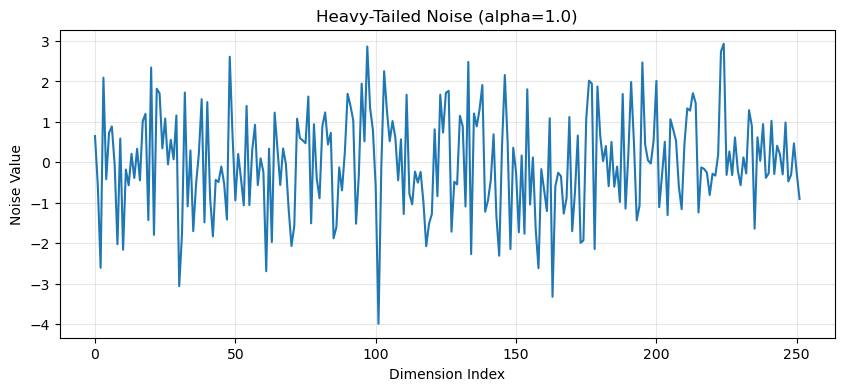

ht_noise 形状: (1, 252)
均值: -0.0079
标准差: 1.2455
最小值: -3.9868
最大值: 2.9320


In [21]:
# plot the noise
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(ht_noise[0])  # 取第一行（因为 size=1）
plt.xlabel('Dimension Index')
plt.ylabel('Noise Value')
plt.title(f'Heavy-Tailed Noise (alpha={alpha})')
plt.grid(True, alpha=0.3)
plt.show()

# 也可以打印一些统计信息
print(f"ht_noise 形状: {ht_noise.shape}")
print(f"均值: {ht_noise.mean():.4f}")
print(f"标准差: {ht_noise.std():.4f}")
print(f"最小值: {ht_noise.min():.4f}")
print(f"最大值: {ht_noise.max():.4f}")

# Training process

## Cosine scheduler (input = T, t, $\alpha$) = (output = $\gamma_{1\rightarrow t}$, $\sigma_{1\rightarrow t}$)

这个里面对应的 T 指的是总的时间步骤，alpha 决定噪声的“重尾”程度。当 $\alpha$ 越小（如 1.5），产生的噪声中偶尔会出现极大的“跳跃”值。 

$t$ 决定了公式里 $\gamma_{1\rightarrow t}$ 和 $\sigma_{1\rightarrow t}$ 到底取数组里的哪一个数

In [22]:
alpha = 1.7

In [23]:
def get_dlpm_cosine_schedule(T, alpha, s=0.008):
    """
    T: 总时间步 (Total time steps)
    alpha: 尾部指数 (Tail index, 1 < alpha <= 2)
    s: 偏移量，防止 t=0 时噪声过大
    """
    # 1. 定义时间步序列
    steps = np.arange(T + 1)
    
    # 2. 计算累积比例函数 f(t) [余弦曲线核心]
    # 使用余弦平方函数，确保加噪过程平滑
    ft = np.cos(((steps / T) + s) / (1 + s) * (np.pi / 2))**2
    
    # 3. 计算累积噪声控制序列 alpha_bar (在 DLPM 中对应缩放逻辑)
    # alpha_bar 决定了原始信号保留的比例
    alphas_bar = ft / ft[0]
    
    # 4. 根据 alpha_bar 计算 DLPM 特有的调度参数
    # gamma_1_to_t: 位置/衰减系数 (控制原始数据 Y0 保留比例)
    gamma_1_to_t = (alphas_bar)**(1 / alpha)
    
    # sigma_1_to_t: 尺度/噪声系数 (控制注入重尾噪声的强度)
    # 基于尺度保持原则: gamma^alpha + sigma^alpha = 1
    sigma_1_to_t = (1 - alphas_bar)**(1 / alpha)
    
    return gamma_1_to_t[1:], sigma_1_to_t[1:]

# 使用示例 当t为1000时
T = 1000

# 我们获取对应的$\gamma_{1\rightarrow t}$ 和 $\sigma_{1\rightarrow t}$ 
gamma_bar, sigma_bar = get_dlpm_cosine_schedule(T, alpha)
# 这个里面的的下标 对应的是不同的t

在你的函数返回 gamma_1_to_t[1:] 后：\
gamma_bar[0] 对应的是 $t=1$ 时的 $\gamma_{1 \to 1}$。 \
gamma_bar[19] 对应的是 $t=20$ 时的 $\gamma_{1 \to 20}$。 

注意：如果你想直接用 gamma_bar[20] 获取 $t=20$ 的值，你需要确保数组长度足够（即 steps 是 T+1 且不切片，或者在调用时意识到索引偏移了 1 位）。‘

In [24]:
gamma_bar[20]

0.9988902916904095

Get $Y_t$ with formula: 

$Y_t = \gamma_{1\rightarrow t}Y_0 + \sigma_{1\rightarrow t}\overline{A}_t^{1/2}G_t$ 

In [25]:


def sample_positive_stable(alpha, batch_size, device='cpu'):
    """
    手动实现正稳定分布采样 S_{alpha/2, 1}(0, c_A)
    """
    alpha_s = alpha / 2
    # 1. 采样辅助变量 U ~ Uniform(-pi/2, pi/2) 和 W ~ Exponential(1)
    U = (torch.rand(batch_size, device=device) - 0.5) * np.pi
    W = -torch.log(torch.rand(batch_size, device=device))
    
    # 2. 计算尺度参数 c_A
    c_A = np.cos(np.pi * alpha / 4)**(2 / alpha)
    
    # 3. CMS 算法核心变换 (针对 beta=1 的简化公式)
    # 这里的 phi 是相位偏移量
    phi = np.pi / 2 
    
    # 计算变换公式
    part1 = torch.sin(alpha_s * (phi + U)) / (torch.cos(U)**(1/alpha_s))
    part2 = (torch.cos(U - alpha_s * (phi + U)) / W)**((1 - alpha_s) / alpha_s)
    
    A = part1 * part2
    
    # 乘以尺度参数 c_A
    return A * c_A


A_samples = sample_positive_stable(alpha, batch_size=1)
A_half = torch.sqrt(A_samples) # 得到公式中的 \overline{A}_t^{1/2}

In [26]:
def get_Y_t(Y_0, t, gamma_bar, sigma_bar, noise, A_half):
    # noise 对应公式中的 G_t（标准高斯噪声）
    # A_half 对应公式中的 \overline{A}_t^{1/2}
    # 替换后的公式实现了重尾噪声的注入
    return gamma_bar[t] * Y_0 + sigma_bar[t] * (A_half * noise)

In [27]:
# # get final Y_t

# Y_0 = targets
# Y_t = get_Y_t(Y_0, t, gamma_bar[t], sigma_bar[t],g_noise, A_half)

Define loss function

In [28]:
# error = model(Y_t, t) - g_noise * A_half
# mse = torch.mean(error**2)
# loss = torch.sqrt(mse)

# loss.backward()

# Model building

In [ ]:
# 导入 DLPM 模型
from DLPM_model import Unet1D, GaussianDiffusion1D

# 模型参数设置
seq_length = 252  # 序列长度（从数据处理中得知）
channels = 1      # 通道数（1D序列）
dim = 64          # 基础维度
timesteps = 1000  # 扩散时间步数

# 条件特征列（只作为 condition 使用，不改变原数据）
cond_cols = ['volatility', 'risk_free_rate', 'contract_calendar_days', 'trading_ratio', 'asset_underlying_id','S_0']

cond_dim = len(cond_cols)

# 1. 创建 U-Net 模型（带 condition 嵌入）
# 注意：252能被2和4整除，但不能被8整除
# 所以使用(1, 2, 4)而不是(1, 2, 4, 8)，这样只有2次下采样
model = Unet1D(
    dim=dim,
    channels=channels,
    dim_mults=(1, 2, 4),  # 维度倍数（减少下采样次数以适配252长度）
    dropout=0.1,
    cond_dim=cond_dim      # 条件向量维度
)

# 2. 创建扩散模型（DLPM - 使用重尾噪声）
alpha = 1.7  # DLPM尾部指数（1 < alpha <= 2），alpha=2时为标准高斯，alpha<2时为重尾分布
diffusion = GaussianDiffusion1D(
    model=model,
    seq_length=seq_length,
    timesteps=timesteps,
    objective='pred_noise',
    beta_schedule='cosine',
    use_dlpm=True,    # 启用DLPM
    alpha=alpha       # 尾部指数（1 < alpha <= 2）
)

print("DLPM模型创建完成！")
print(f"序列长度: {seq_length}, 通道数: {channels}, 时间步数: {timesteps}")
print(f"尾部指数 alpha: {alpha} (alpha<2时为重尾分布)")


DLPM模型创建完成！
序列长度: 252, 通道数: 1, 时间步数: 1000
尾部指数 alpha: 1.7 (alpha<2时为重尾分布)


In [30]:
# 数据适配：将 y 数据转换为扩散模型需要的格式 (batch_size, channels, seq_length)
from torch.utils.data import Dataset

# y_train_split 形状是 (N, 252)，需要转换为 (N, 1, 252)
y_train_tensor = torch.tensor(y_train_split, dtype=torch.float32).unsqueeze(1)  # (N, 1, 252)
y_val_tensor = torch.tensor(y_val_split, dtype=torch.float32).unsqueeze(1)     # (N, 1, 252)

# 根据 cond_cols 从 X_train_scaled 中找到列索引
cond_idx = [X_train_scaled.columns.get_loc(c) for c in cond_cols]

# 从 X_train_split / X_val_split 提取对应的 condition 数组（不修改原数据）
cond_train = X_train_split[:, cond_idx].astype(np.float32)
cond_val   = X_val_split[:, cond_idx].astype(np.float32)

# mask_train, mask_val 形状为 (N, 252)，与 y_* 对应
mask_train_tensor = torch.tensor(mask_train, dtype=torch.float32)  # (N, 252)
mask_val_tensor   = torch.tensor(mask_val,   dtype=torch.float32)  # (N, 252)

class DiffusionCondDataset(Dataset):
    def __init__(self, y_tensor, cond_array, mask_tensor):
        self.y = y_tensor                    # (N, 1, L)
        self.cond = torch.tensor(cond_array, dtype=torch.float32)  # (N, cond_dim)
        self.mask = mask_tensor             # (N, L)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.y[idx], self.cond[idx], self.mask[idx]

# 创建适配的数据集（扩散模型需要序列 + condition + mask）
train_dataset_diffusion = DiffusionCondDataset(y_train_tensor, cond_train, mask_train_tensor)
val_dataset_diffusion   = DiffusionCondDataset(y_val_tensor,   cond_val,   mask_val_tensor)

print(f"训练数据形状: {y_train_tensor.shape}, 条件形状: {cond_train.shape}, mask 形状: {mask_train_tensor.shape}")
print(f"验证数据形状: {y_val_tensor.shape}, 条件形状: {cond_val.shape}, mask 形状: {mask_val_tensor.shape}")


训练数据形状: torch.Size([25673, 1, 252]), 条件形状: (25673, 4), mask 形状: torch.Size([25673, 252])
验证数据形状: torch.Size([6419, 1, 252]), 条件形状: (6419, 4), mask 形状: torch.Size([6419, 252])


In [31]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
diffusion = diffusion.to(device)
print(f"使用设备: {device}")

# 创建优化器
optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)

# 创建训练 DataLoader
train_loader_diffusion = DataLoader(train_dataset_diffusion, batch_size=32, shuffle=True)
val_loader_diffusion   = DataLoader(val_dataset_diffusion,   batch_size=32, shuffle=False)  # 如需验证可用


使用设备: cuda


In [32]:
# 训练循环（带 condition）
num_epochs = 5  # 训练轮数
print_every = 100  # 每100个batch打印一次

diffusion.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    num_batches = 0
    
    for batch_idx, (data, cond, mask) in enumerate(train_loader_diffusion):
        # data 形状: (batch_size, 1, 252)
        data = data.to(device)
        cond = cond.to(device)
        mask = mask.to(device)
        
        # 前向传播：扩散模型会自动添加噪声并计算损失（传入 condition + mask）
        loss = diffusion(data, mask=mask, model_forward_kwargs={'cond': cond})
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        # 打印进度
        if (batch_idx + 1) % print_every == 0:
            avg_loss = total_loss / num_batches
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}, Loss: {avg_loss:.4f}")
    
    # 每个epoch结束打印平均损失
    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    print(f"Epoch {epoch+1}/{num_epochs} 完成，平均损失: {avg_loss:.4f}\n")

print("训练完成！")


Epoch 1/5, Batch 100, Loss: 0.3910
Epoch 1/5, Batch 200, Loss: 0.2457
Epoch 1/5, Batch 300, Loss: 0.1817
Epoch 1/5, Batch 400, Loss: 0.1485
Epoch 1/5, Batch 500, Loss: 0.1373
Epoch 1/5, Batch 600, Loss: 0.1224
Epoch 1/5, Batch 700, Loss: 0.1143
Epoch 1/5, Batch 800, Loss: 0.1257
Epoch 1/5 完成，平均损失: 0.1253

Epoch 2/5, Batch 100, Loss: 0.0673
Epoch 2/5, Batch 200, Loss: 0.1189
Epoch 2/5, Batch 300, Loss: 0.3930
Epoch 2/5, Batch 400, Loss: 0.3127
Epoch 2/5, Batch 500, Loss: 0.2748
Epoch 2/5, Batch 600, Loss: 0.2428
Epoch 2/5, Batch 700, Loss: 0.2144
Epoch 2/5, Batch 800, Loss: 0.1911
Epoch 2/5 完成，平均损失: 0.1904

Epoch 3/5, Batch 100, Loss: 0.0813
Epoch 3/5, Batch 200, Loss: 0.0609
Epoch 3/5, Batch 300, Loss: 0.0549
Epoch 3/5, Batch 400, Loss: 0.0491
Epoch 3/5, Batch 500, Loss: 0.0451
Epoch 3/5, Batch 600, Loss: 0.1213
Epoch 3/5, Batch 700, Loss: 0.1150
Epoch 3/5, Batch 800, Loss: 0.1278
Epoch 3/5 完成，平均损失: 0.1276

Epoch 4/5, Batch 100, Loss: 0.0737
Epoch 4/5, Batch 200, Loss: 0.0552
Epoch 4/5

# Monte Carlo method